# Quality Prediction in a Mining Process

The main goal is to use this data to predict how much impurity is in the ore concentrate. As this impurity is measured every hour, if we can predict how much silica (impurity) is in the ore concentrate, we can help the engineers, giving them early information to take actions (empowering!). Hence, they will be able to take corrective actions in advance (reduce impurity, if it is the case) and also help the environment (reducing the amount of ore that goes to tailings as you reduce silica in the ore concentrate).

## Loading the data from _Weight and Biases_ and importing python packages

In [1]:
import wandb
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from copy import deepcopy

%load_ext autoreload
%autoreload 2

In [2]:
run = wandb.init(project="ihm", group="eda", save_code=True)
local_path = wandb.use_artifact("cleansed_mining_flotation_plant.csv:latest").file()
df = pd.read_csv(local_path, decimal=",",parse_dates=["date"], index_col="date")
df = df.iloc[:0,-1].apply(pd.to_numeric)

wandb: Currently logged in as: grabe. Use `wandb login --relogin` to force relogin


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 699840 entries, 2017-04-01 00:00:00 to 2017-09-09 23:59:40
Data columns (total 23 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   % Iron Feed                   699840 non-null  float64
 1   % Silica Feed                 699840 non-null  float64
 2   Starch Flow                   699840 non-null  float64
 3   Amina Flow                    699840 non-null  float64
 4   Ore Pulp Flow                 699840 non-null  float64
 5   Ore Pulp pH                   699840 non-null  float64
 6   Ore Pulp Density              699840 non-null  float64
 7   Flotation Column 01 Air Flow  699840 non-null  float64
 8   Flotation Column 02 Air Flow  699840 non-null  float64
 9   Flotation Column 03 Air Flow  699840 non-null  float64
 10  Flotation Column 04 Air Flow  699840 non-null  float64
 11  Flotation Column 05 Air Flow  699840 non-null  float64
 12  Flotation 

In [4]:
df.head()

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
date,,,,,,,,,,,,,,,,,,,,,
2017-04-01 00:00:00,59.72,9.22,2195.31,523.283,395.785,9.45255,1.71765,176.379742,184.619458,184.292819,...,249.082,807.178,799.417,799.614,461.455,476.486,421.792,449.983,64.03,3.11
2017-04-01 00:00:20,59.72,9.22,2160.89,559.637,401.740,9.65336,1.76695,176.331150,184.917458,184.628292,...,251.697,796.664,801.230,809.079,472.089,444.256,438.702,430.522,64.03,3.11
2017-04-01 00:00:40,59.72,9.22,2144.96,558.775,402.982,9.65564,1.76722,176.330727,184.920049,184.631209,...,249.989,802.674,780.025,796.883,475.400,449.314,424.064,432.860,64.03,3.11
2017-04-01 00:01:00,59.72,9.22,2149.07,561.790,403.241,9.65793,1.76750,176.330305,184.922640,184.634126,...,250.518,805.994,777.026,793.741,472.197,449.925,444.297,435.181,64.03,3.11
2017-04-01 00:01:20,59.72,9.22,2152.87,566.904,402.968,9.66021,1.76778,176.329882,184.925232,184.637043,...,252.257,807.858,783.881,795.499,465.469,448.131,483.404,437.493,64.03,3.11


In [5]:
dataset = deepcopy(df)

In [6]:
# df = deepcopy(dataset)

In [7]:
df.groupby(df.index.floor('H')).size().reset_index(name='count').query("count>180")

,date,count


## Exploring the data

First, we need to understand and actually see the data. That said, some plots and comments about some features will be done in the following cells.

    1. Input Material Features:
    
        * % Iron Feed
        * % Silica Feed
        * Starch Flow
        * Amina Flow
        * Ore Pulp Flow
        
    2. Context Features:
    
        * Ore Pulp pH
        * Ore Pulp Density
        
    3. Process Features:
    
        * Flotation Column Air Flow (1, 2, 3, ...)
        * Flotation Column Air Level (1, 2, 3, ...)

In [23]:
df['Shift'] = np.nan
for idx in df.between_time(start_time='00:00:00', end_time='08:00:00').index.tolist():
    df.loc[idx, "Shift"] = "A"
for idx in df.between_time(start_time='08:01:00', end_time='16:00:00').index.tolist():
    df.loc[idx, "Shift"] = "B"
for idx in df.between_time(start_time='16:01:00', end_time='23:59:59').index.tolist():
    df.loc[idx, "Shift"] = "C"

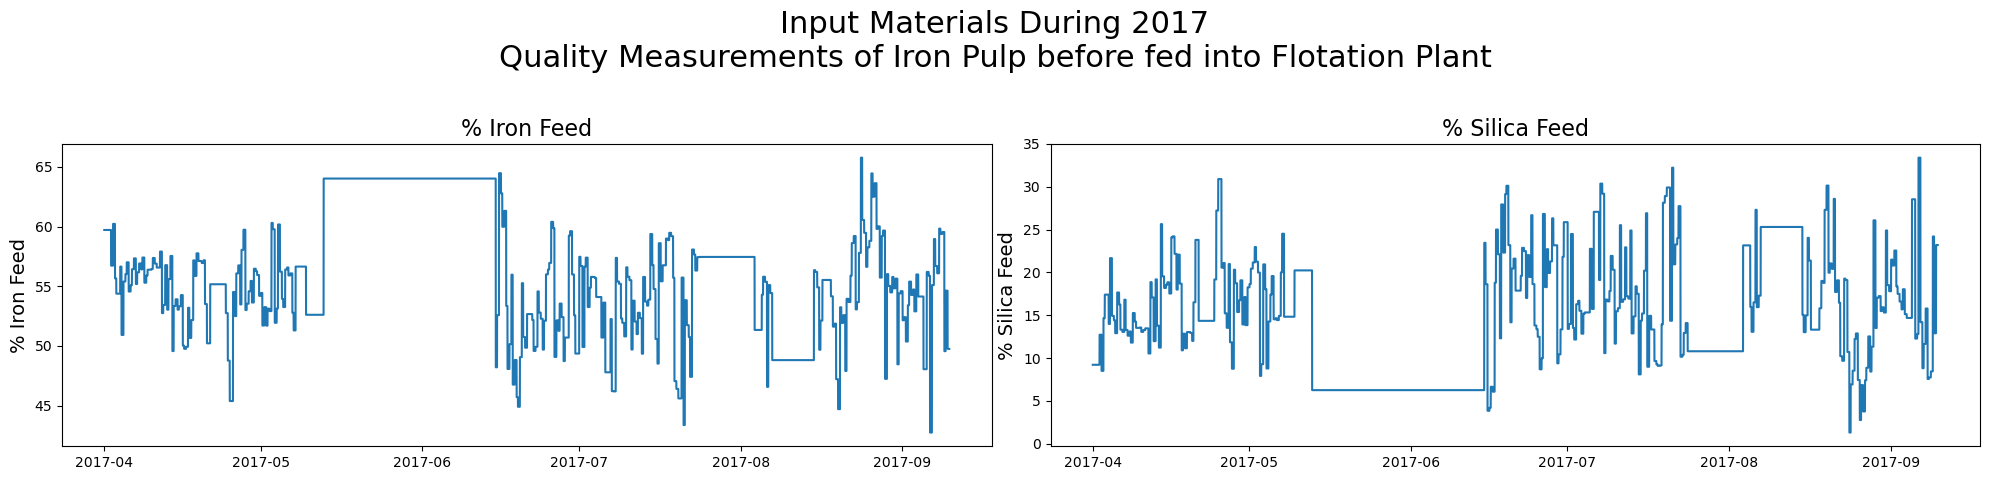

In [56]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

for idx, col in enumerate(df.columns[0:3]):
    try:
        ax = plt.subplot(1,2, (idx+1))
        ax.plot(df[col])
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.set_ylabel(col, fontdict={'fontsize':14})
        ax.set_title(f'{col}', fontdict={'fontsize':16})
        
    except:
        pass
    
plt.suptitle('Input Materials During 2017\nQuality Measurements of Iron Pulp before fed into Flotation Plant', fontsize=22)
plt.tight_layout(pad=1.08, h_pad=.8, w_pad=.5, rect=[0, 0.03, 1, 0.95])
plt.show()

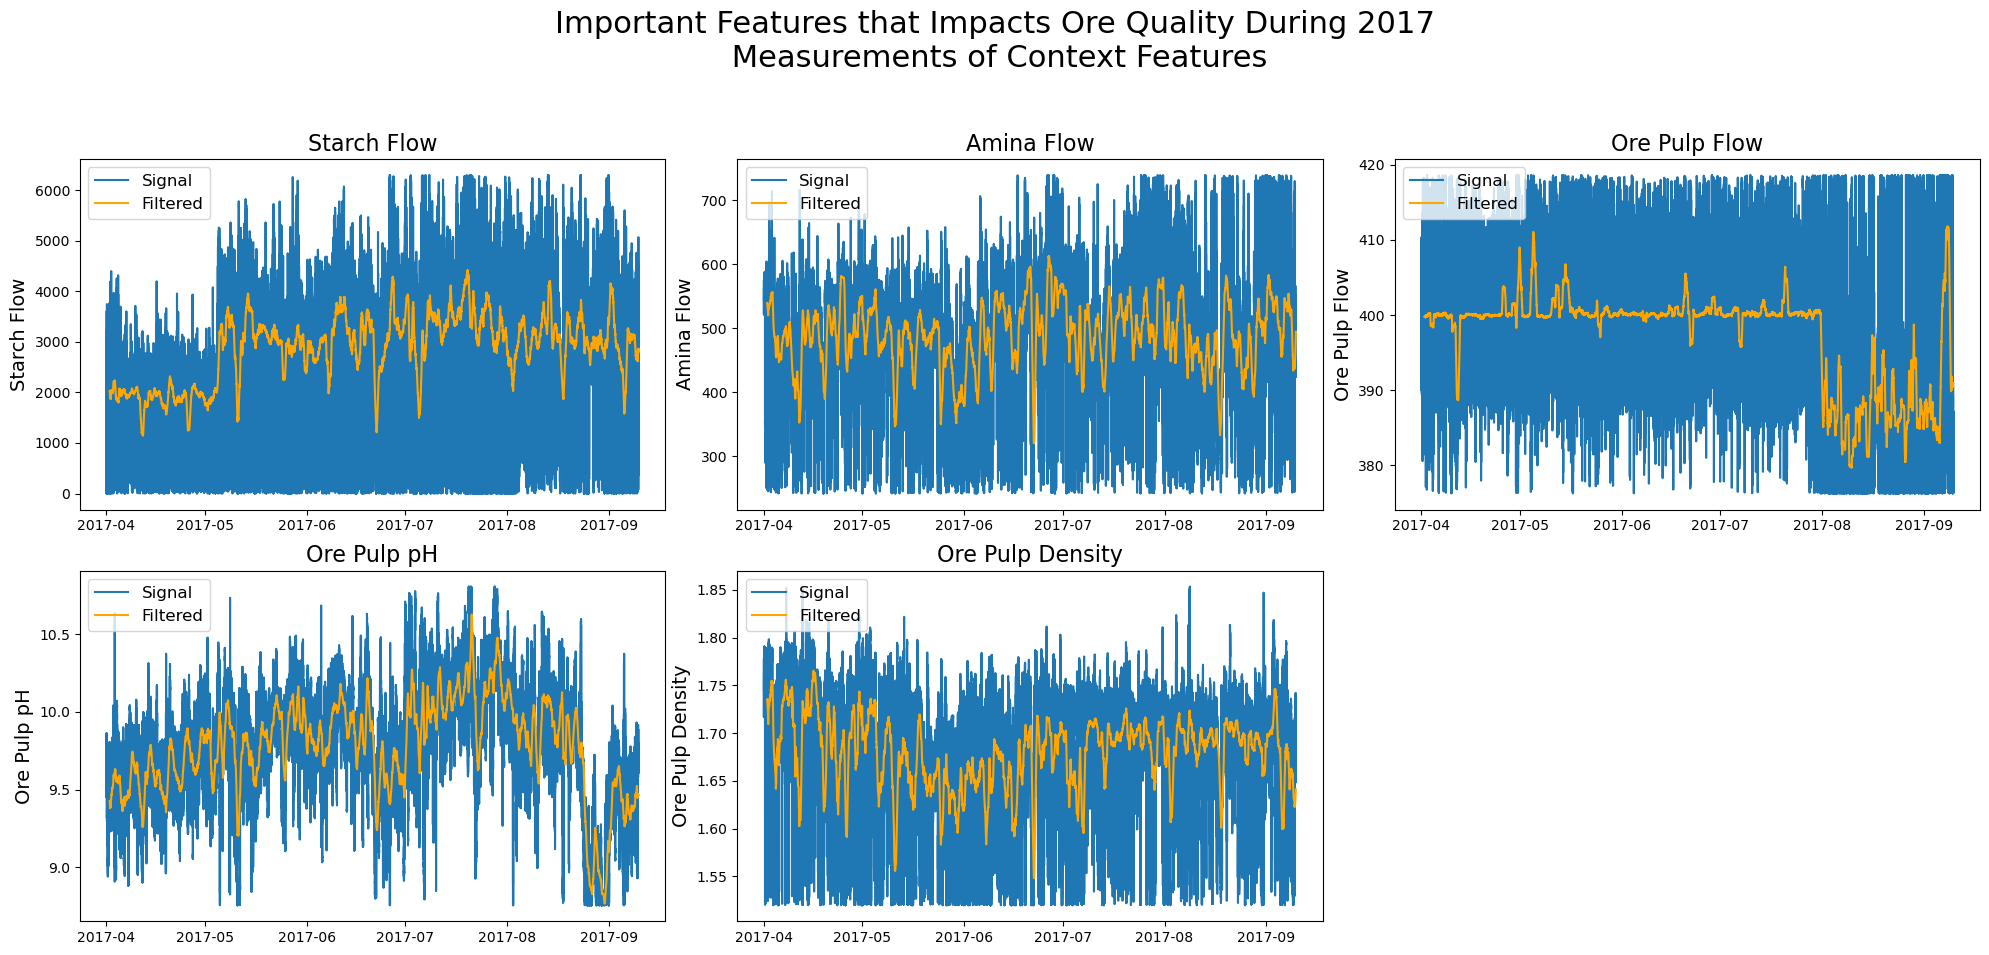

In [85]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

for idx, col in enumerate(df.columns[2:7]):
    try:
        ax = plt.subplot(2,3, (idx+1))
        ax.plot(df[col], label='Signal')
        ax.plot(df[col].rolling(int(3*60*24)).mean(), color='orange', label='Filtered')
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.set_ylabel(col, fontdict={'fontsize':14})
        ax.set_title(f'{col}', fontdict={'fontsize':16})
        ax.legend(loc='upper left', fontsize=12)
    except:
        pass
fig.delaxes(axes[1][-1])
plt.suptitle('Important Features that Impacts Ore Quality During 2017\n Measurements of Context Features', fontsize=22)
plt.tight_layout(pad=1.08, h_pad=.8, w_pad=.5, rect=[0, 0.03, 1, 0.95])
plt.show()

In [78]:
run.finish()